In [49]:
import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from plotting import label_axes

In [50]:
from utils import GeV_over_c

# Particle acceleration at planar shock with a free escape surface

The equation we're solving is a stationary advection-diffusion equation:

$$
u \frac{\partial f}{\partial z}
- \frac 1 3 \frac{du}{dz} p \frac{\partial f}{\partial p}
= \frac{\partial}{\partial z} \left[ D \frac{\partial f}{\partial z} \right]
+ Q
$$

Here:
- $f(z, p)$ is an isotropic part of the full phase-space distribution function, $f = \frac{dN}{dz dp}$
- $u$ is a plasma velocity field; in a shock reference frame we write
  $u = \begin{cases} -V \quad & z >0 \\ -V/r  &z<0 \end{cases}$,
  where $V$, shock velocity and $r$, it's compression ratio, are assumed to be known
  - consequently, we write $\frac{\partial u}{\partial z} = - V \frac{r - 1}{r} \delta(z)$
- $D$ is a diffusion coefficient, constant up- ($z>0$) and downstream ($z<0$) and equal to $D_u$ and $D_d$ respectively
- $Q$ is an injection term, phenomenologically modelling the process of initial spontaneous acceleration of particles
  from the thermal distribution tail to some initial momentum $p_i$, $Q \propto \delta(p - p_i) \delta(z)$

Boundary condition:
- $f(z_0, p) = 0$ - free streaming at some distance $z_0 > 0$ (in upstream)

## Basic geometry and shock properties

In [51]:
r = 4  # compression factor
sigma = 3 * r / (r - 1)
V = 1e-4 * const.c
z0_example = 20 * u.pc

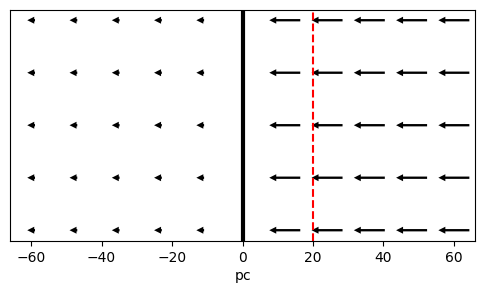

In [52]:
_, ax_z = plt.subplots(figsize=(6, 3))
ax_z: plt.Axes

quiver_scale = 15  # arbitrary!
quiver_kw = {"pivot": "middle", "width": 5e-3, "headlength": 3, "headaxislength": 3}

nz0 = 3
n_side = 5
upstream_grid_z = np.linspace(0, nz0 * z0_example, n_side + 1)[1:]
grid_perp = np.linspace(-5, 5, n_side)
ax_z.quiver(
    upstream_grid_z,
    grid_perp,
    *np.meshgrid(
        (-np.ones_like(upstream_grid_z)).value,
        np.zeros_like(grid_perp),
    ),
    scale=quiver_scale,
    **quiver_kw,
)

downstream_grid_z = np.linspace(-nz0 * z0_example, 0, n_side + 1)[:-1]
ax_z.quiver(
    downstream_grid_z,
    grid_perp,
    *np.meshgrid(
        (-np.ones_like(upstream_grid_z)).value,
        np.zeros_like(grid_perp),
    ),
    scale=quiver_scale * r,
    **quiver_kw,
)

ax_z.axvline(0, linewidth=3, color="k")
ax_z.axvline(z0_example, linestyle="--", color="r")
ax_z.set_yticks([])
plt.show()

## Acceleration conditions

We use example value of $Q_0 = 1~\mathrm{s^{-1}}$ and injection momentum corresponding
to an upper tail ($10 k_B T$) of Maxwell distribution for $T = 10^{6}~\mathrm{K}$, corresponding
to a hot plasma.

For $D_u$ we use a value one order of magnitude smaller than the Galactic average of $10^{28}~\mathrm{cm^2 / sec}$

In [53]:
def E_to_p(T: u.Quantity[u.eV]) -> u.Quantity[GeV_over_c]:
    gamma = 1 + (T / (const.m_p * const.c**2)).decompose()
    v = const.c * np.sqrt(1 - gamma**-2)
    return (gamma * const.m_p * v).to(GeV_over_c)


In [54]:
# injection at the shock
Q0 = 1 / (u.s * u.au**2 * GeV_over_c**2)

T_SNR = 1e6 * u.K
E_inj = 10 * const.k_B * T_SNR
p_inj = E_to_p(E_inj)
print(f"injection of protons at kin. energy T = {E_inj.to(u.eV):.2e} (momentum p = {p_inj:.2e}")

injection of protons at kin. energy T = 8.62e+02 eV (momentum p = 1.27e-03 GeV/c


In [55]:
delta = 1 / 3
D0 = 1e27 * u.cm**2 / u.s
p0 = E_to_p(100 * u.GeV)
D = lambda p: D0 * (p / p0) ** delta
l_p = lambda p: (D(p) / V).to(u.pc)
dldp = lambda p: l_p(p) * delta / p

## Limiting case $z_0 \to \infty$

Simple analytical solution exists:

$$
f(z, p) = n_0 \left( \frac{p}{p_i} \right)^{-\alpha}
\begin{cases}
e^{-z / l(p)} \quad & z>0 \\ 
1 \quad & z \le 0 \\ 
\end{cases}
$$

Here $\alpha \equiv \frac{3r}{r - 1}$ – spectral index ($4$ for strong shock), $l(p) \equiv \frac{D_u(p)}{V}$ – diffusion length in the upstream.
$n_0 = \frac{\alpha Q_0}{V p_i}$ – spectrum normalization.

In [56]:
F_UNIT = 1 / (u.pc**3 * GeV_over_c**3)

def f_limit(p: u.Quantity[GeV_over_c], z: u.Quantity[u.pc]) -> u.Quantity[F_UNIT]:
    n0 = sigma * Q0 / (V * p_inj)
    return (n0 * (p / p_inj) ** (-sigma) * np.exp(-np.maximum(z, 0) / l_p(p))).to(F_UNIT)


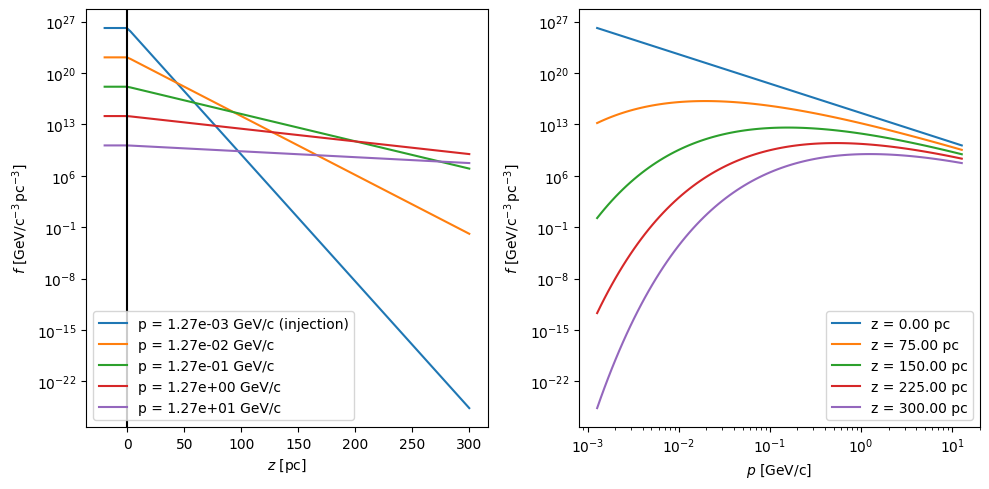

In [57]:
_, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax_z = axes[0]
ax_p = axes[1]

log10pinj = np.log10(p_inj.to(GeV_over_c).value)

z_grid = np.linspace(-1 * z0_example, 15 * z0_example, 100)
p_grid = np.logspace(log10pinj, 4 + log10pinj, 5) * GeV_over_c
for idx, pp in enumerate(p_grid):
    label = f"p = {pp:.2e}"
    if idx == 0:
        label = label + " (injection)"
    ax_z.plot(z_grid, f_limit(pp, z_grid), label=label)
ax_z.set_yscale("log")
ax_z.axvline(0, color="k")
label_axes(ax_z, "z", "f")
ax_z.legend()

z_grid = np.linspace(0, 15 * z0_example, 5)
p_grid = np.logspace(log10pinj, 4 + log10pinj, 100) * GeV_over_c
for z in z_grid:
    ax_p.loglog(p_grid, f_limit(p_grid, z), label=f"z = {z:.2f}")
label_axes(ax_p, "p", "f")
ax_p.legend()

plt.tight_layout()
plt.show()

## General case

As before, the solution is separable in terms of $p$ and $z$. The latter is trivial:

$$
f(z, p) = n(p) \begin{cases}
e^{-z / l(p)} - e^{-z_0 / l(p)} \quad & z > 0 \\
1 - e^{-z_0 / l(p)} \quad & z \le 0
\end{cases}
$$

Substituting this form into the original PDE and integrating it across $z=0$,
we get the following equation for $n(p)$:
$$
p V \frac{r - 1}{3r} \frac{\partial}{\partial p} \left( n(p) (1 - e^{-z_0 / l(p)}) \right) = - D_u n(p) \frac{1}{l(p)} + Q_0 \delta(p - p_i) \\
\frac {p V}{\alpha} \left( \frac{dn}{dp} (1 - e^{-z_0 / l(p)}) - n(p) e^{-z_0 / l(p)} \frac{z_0}{l(p)^2} \frac{dl}{dp} \right) + V n(p) = Q_0 \delta(p - p_i)
$$

For $p > p_i$ this transforms into

$$
\frac{dn}{dp} = n(p) \frac{ e^{-z_0 / l(p)} \frac{z_0}{l(p)^2} \frac{dl}{dp} - \frac{\alpha}{p} }{1 - e^{-z_0 / l(p)}}
$$

... which gives

$$
n(p) = n_0 \exp \left[ \int_{p_i}^{p} dp' \frac{ e^{-z_0 / l(p')} \frac{z_0}{l(p')^2} \frac{dl}{dp'} - \frac{\alpha}{p'} }{1 - e^{-z_0 / l(p')}} \right]
$$



In [58]:
import scipy.integrate


def integrand(log_pp: float, z0: u.Quantity[u.pc]) -> float:
    pp = np.exp(log_pp) * GeV_over_c
    jacobian = pp
    lp = l_p(pp)
    exp = np.exp(-(z0 / lp).decompose())
    return jacobian * (exp * z0 / lp**2 * dldp(pp) - sigma / pp) / (1 - exp)


def n_p_shape(p: u.Quantity[GeV_over_c], z0: u.Quantity[u.pc]) -> float:
    integral, *_ = scipy.integrate.quad(
        integrand,
        a=np.log(p_inj.to(GeV_over_c).value),
        b=np.log(p.to(GeV_over_c).value),
        args=(z0,),
    )
    return np.exp(integral)


def f_numint(
    p: u.Quantity[GeV_over_c], z: u.Quantity[u.pc], z0: u.Quantity[u.pc]
) -> u.Quantity[F_UNIT]:
    # this n0 is wrong! we use it only for ease of comparison w/ limit case
    n0 = sigma * Q0 / (V * p_inj)
    n_p = n0 * n_p_shape(p, z0)
    return (n_p * (np.exp(-np.maximum(z, 0) / l_p(p)) - np.exp(-z0 / l_p(p)))).to(
        F_UNIT
    )

### Spectral shape

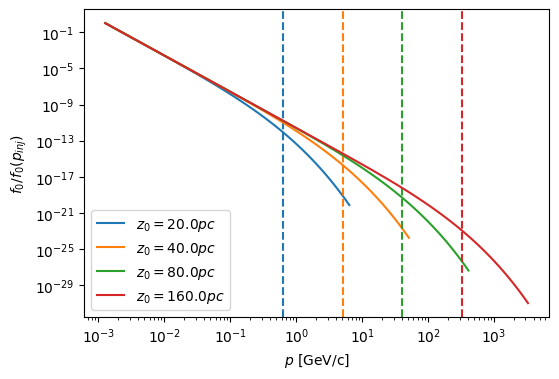

In [59]:
_, ax = plt.subplots(figsize=(6, 4))

for z0 in [20 * u.pc, 40 * u.pc, 80 * u.pc, 160 * u.pc]:
    l0 = D0 / V
    p_cutoff = p0 * (z0 / l0)**(1/delta)
    p_grid = np.logspace(log10pinj, 1 + np.log10(p_cutoff.to(GeV_over_c).value), 100) * GeV_over_c
    line, *_ = ax.loglog(
        p_grid,
        np.array([n_p_shape(p, z0=z0) for p in p_grid]),
        label=f"$z_0 = {z0}$",
    )
    ax.axvline(p_cutoff, color=line.get_color(), linestyle="--")

label_axes(ax, "p", "f_0 / f_0(p_{inj})")
ax.legend()
plt.show()

alpha: 0.5287951434460952 +/- 0.00220571057735769


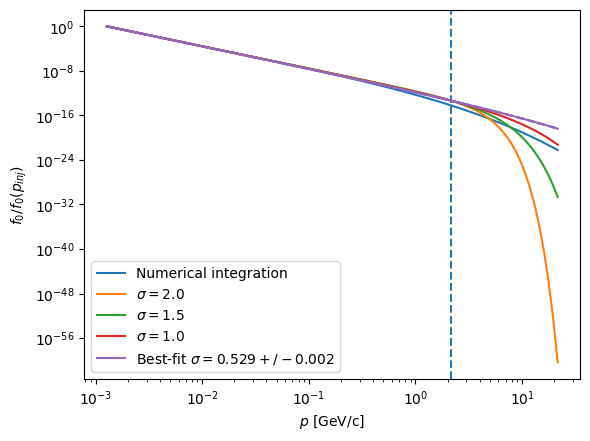

In [60]:
import scipy.optimize


fig, ax = plt.subplots()

z0_fit = 30 * u.pc
l0 = D0 / V
p_cutoff = p0 * (z0_fit / l0) ** (1 / delta)

p_grid = (
    np.logspace(log10pinj, 1 + np.log10(p_cutoff.to(GeV_over_c).value), 100)
    * GeV_over_c
)
spectrum = np.array([n_p_shape(p, z0=z0_fit) for p in p_grid])
line, *_ = ax.loglog(p_grid, spectrum, label="Numerical integration")
ax.axvline(p_cutoff, color=line.get_color(), linestyle="--")

# attempting to fit


def cutoff(p, sigma):
    p = p * GeV_over_c
    return np.exp(-((p / p_cutoff) ** sigma))


fitted = lambda sigma: (p_grid / p_inj) ** (-4) * cutoff(
    p_grid.to(GeV_over_c).value, sigma=sigma
)

for sigma in (2.0, 1.5, 1.0):
    ax.loglog(p_grid, fitted(sigma), label=f"$ \\sigma = {sigma} $")

popt, pcov = scipy.optimize.curve_fit(
    f=cutoff,
    xdata=p_grid.to(GeV_over_c).value,
    ydata=(spectrum / ((p_grid / p_inj) ** (-4))).decompose().value,
    p0=(1.0,),
    bounds=(0.0, 5.0),
)
sigma_co = popt[0]
sigma_co_err = pcov[0][0]
print(f"alpha: {sigma_co} +/- {sigma_co_err}")

approxline, *_ = ax.loglog(
    p_grid,
    fitted(sigma_co),
    label=f"Best-fit $ \\sigma = {sigma_co:.3f} +/- {sigma_co_err:.3f} $",
)
for sign in (-1, 1):
    ax.loglog(
        p_grid,
        fitted(sigma_co + sign * sigma_co_err),
        color=approxline.get_color(),
        linestyle="--",
    )


ax.legend()
label_axes(ax, "p", "f_0 / f_0(p_{inj})")
plt.show()

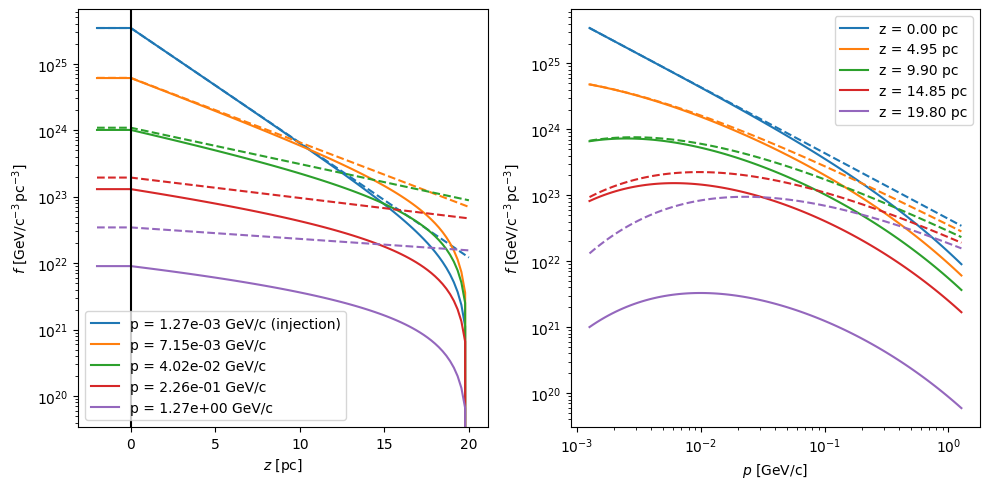

In [61]:
_, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax_z = axes[0]
ax_p = axes[1]

log10pinj = np.log10(p_inj.to(GeV_over_c).value)

z_grid = np.linspace(-0.1 * z0_example, z0_example, 100)
p_grid = np.logspace(log10pinj, 3 + log10pinj, 5) * GeV_over_c
for idx, p in enumerate(p_grid):
    label = f"p = {p:.2e}"
    if idx == 0:
        label = label + " (injection)"
    line, *_ = ax_z.plot(z_grid, f_numint(p, z_grid, z0=z0_example), label=label)
    ax_z.plot(z_grid, f_limit(p, z_grid), color=line.get_color(), linestyle="--")
ax_z.set_yscale("log")
ax_z.axvline(0, color="k")
label_axes(ax_z, "z", "f")
ax_z.legend()

z_grid = np.linspace(0, 0.99 * z0_example, 5)
p_grid = np.logspace(log10pinj, 3 + log10pinj, 100) * GeV_over_c
for z in z_grid:
    label = f"z = {z:.2f}"
    line, *_ = ax_p.loglog(
        p_grid, u.Quantity([f_numint(p, z, z0=z0_example) for p in p_grid]), label=label
    )
    ax_p.loglog(p_grid, f_limit(p_grid, z), color=line.get_color(), linestyle="--")
label_axes(ax_p, "p", "f")
ax_p.legend()

plt.tight_layout()
plt.show()